In [1]:
import numpy as np
import os

from type_definitions.test_case import TestCase
from type_definitions.test_result import TestResult
from type_definitions.utils import *
from sklearn.mixture import GaussianMixture
from sklearn.manifold import MDS
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import OPTICS

## Simulation


In [ ]:
seed = 100
save_plot = False
use_cached_distance_matrix = True


np.random.seed(seed)

cases = generate_cases(100)
results = evaluate_cases(cases)
trajectories = [r.trajectory for r in results if not r.simulation_failed]
valid_results = [r for r in results if not r.simulation_failed]
print(f"Generated {len(trajectories)} valid trajectories")
print(
    f"Crashed: {sum(1 for r in valid_results if r.crashed)}, Safe: {sum(1 for r in valid_results if not r.crashed)}"
)

Generated 52 valid trajectories
Crashed: 37, Safe: 15


In [4]:
os.makedirs("cache", exist_ok=True)
distance_matrix_file = (
    f"cache/altitude_distance_matrix_seed{seed}_size{len(trajectories)}.npy"
)

if use_cached_distance_matrix and os.path.exists(distance_matrix_file):
    print(f"Loading altitude-based distance matrix from {distance_matrix_file}")
    distance_matrix = np.load(distance_matrix_file)
else:
    print("Calculating pairwise altitude distances...")
    distance_matrix = pairwise_altitude_distances(trajectories)
    np.save(distance_matrix_file, distance_matrix)
    print(f"Altitude distance matrix saved to {distance_matrix_file}")

print(f"Distance matrix shape: {distance_matrix.shape}")

Calculating pairwise altitude distances...
Altitude distance matrix saved to cache/altitude_distance_matrix_seed100_size52.npy
Distance matrix shape: (52, 52)


## OPTIC Clustering


In [ ]:
# OPTICS clustering based on altitude trajectories
optics = OPTICS(min_samples=3, metric="precomputed", cluster_method="xi", xi=0.05)
clusters = optics.fit_predict(distance_matrix)
unique_clusters = np.unique(clusters)
reachability = optics.reachability_
ordering = optics.ordering_

# Calculate cluster statistics
print("Cluster statistics:")
for cluster_id in unique_clusters:
    if cluster_id == -1:  # Skip noise points
        continue
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    crashed_in_cluster = sum(1 for r in cluster_results if r.crashed)
    total_in_cluster = len(cluster_results)
    crash_rate = (
        (crashed_in_cluster / total_in_cluster) * 100 if total_in_cluster > 0 else 0
    )
    print(
        f"    Cluster {cluster_id}: {crashed_in_cluster}/{total_in_cluster} crashed ({crash_rate:.2f}%)"
    )

In [ ]:
# Calculate coverage metrics
total_test_cases = len(valid_results)
noise_points = np.sum(clusters == -1)
cluster_ids = unique_clusters[unique_clusters != -1]  # Exclude noise
num_clusters = len(cluster_ids)

# Calculate cluster sizes and proportions
cluster_sizes = {}
cluster_proportions = {}
cluster_coverage_percentages = {}

for cluster_id in cluster_ids:
    cluster_mask = clusters == cluster_id
    size = np.sum(cluster_mask)
    cluster_sizes[cluster_id] = size
    cluster_proportions[cluster_id] = (
        size / total_test_cases if total_test_cases > 0 else 0
    )
    cluster_coverage_percentages[cluster_id] = cluster_proportions[cluster_id] * 100

# Store coverage metrics
coverage_metrics = {
    "total_test_cases": total_test_cases,
    "num_clusters": num_clusters,
    "noise_points": noise_points,
    "noise_percentage": (
        (noise_points / total_test_cases * 100) if total_test_cases > 0 else 0
    ),
    "cluster_sizes": cluster_sizes,
    "cluster_proportions": cluster_proportions,
    "cluster_coverage_percentages": cluster_coverage_percentages,
}

In [ ]:
# Print coverage metrics summary
print("=" * 60)
print("OPTICS ALTITUDE-BASED CLUSTERING COVERAGE METRICS SUMMARY")
print("=" * 60)
print(f"\nTotal Test Cases: {coverage_metrics['total_test_cases']}")
print(f"Number of Clusters: {coverage_metrics['num_clusters']}")
print(
    f"Noise Points: {coverage_metrics['noise_points']} ({coverage_metrics['noise_percentage']:.2f}%)"
)
print(f"\nCluster Distribution:")
print("-" * 60)

# Sort clusters by size (descending)
sorted_clusters = sorted(cluster_ids, key=lambda x: cluster_sizes[x], reverse=True)

for cluster_id in sorted_clusters:
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    crashed_in_cluster = sum(1 for r in cluster_results if r.crashed)
    total_in_cluster = cluster_sizes[cluster_id]
    crash_rate = (
        (crashed_in_cluster / total_in_cluster) * 100 if total_in_cluster > 0 else 0
    )
    coverage_pct = cluster_coverage_percentages[cluster_id]

    print(
        f"Cluster {cluster_id:2d}: Size={total_in_cluster:3d} ({coverage_pct:5.2f}% coverage) | "
        f"Crashed={crashed_in_cluster:3d}/{total_in_cluster:3d} ({crash_rate:5.2f}%)"
    )

print("-" * 60)

# Calculate cluster size statistics
if len(cluster_sizes) > 0:
    sizes_list = list(cluster_sizes.values())
    print(f"\nCluster Size Statistics:")
    print(f"  Min: {min(sizes_list)}")
    print(f"  Max: {max(sizes_list)}")
    print(f"  Mean: {np.mean(sizes_list):.2f}")
    print(f"  Median: {np.median(sizes_list):.2f}")
    print(f"  Std Dev: {np.std(sizes_list):.2f}")

# Coverage distribution analysis
coverage_values = list(cluster_coverage_percentages.values())
if len(coverage_values) > 0:
    print(f"\nCoverage Distribution:")
    print(f"  Min Coverage: {min(coverage_values):.2f}%")
    print(f"  Max Coverage: {max(coverage_values):.2f}%")
    print(f"  Mean Coverage: {np.mean(coverage_values):.2f}%")
    print(
        f"  Coverage Balance Score: {1 - np.std(coverage_values) / np.mean(coverage_values):.3f} "
        + f"(1.0 = perfectly balanced, lower = more skewed)"
    )

print("=" * 60)
print("=" * 60)
print(f"\nTotal Test Cases: {coverage_metrics['total_test_cases']}")
print(f"Number of Clusters: {coverage_metrics['num_clusters']}")
print(
    f"Noise Points: {coverage_metrics['noise_points']} ({coverage_metrics['noise_percentage']:.2f}%)"
)
print(f"\nCluster Distribution:")
print("-" * 60)

# Sort clusters by size (descending)
sorted_clusters = sorted(cluster_ids, key=lambda x: cluster_sizes[x], reverse=True)

for cluster_id in sorted_clusters:
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    crashed_in_cluster = sum(1 for r in cluster_results if r.crashed)
    total_in_cluster = cluster_sizes[cluster_id]
    crash_rate = (
        (crashed_in_cluster / total_in_cluster) * 100 if total_in_cluster > 0 else 0
    )
    coverage_pct = cluster_coverage_percentages[cluster_id]

    print(
        f"Cluster {cluster_id:2d}: Size={total_in_cluster:3d} ({coverage_pct:5.2f}% coverage) | "
        f"Crashed={crashed_in_cluster:3d}/{total_in_cluster:3d} ({crash_rate:5.2f}%)"
    )

print("-" * 60)

# Calculate cluster size statistics
if len(cluster_sizes) > 0:
    sizes_list = list(cluster_sizes.values())
    print(f"\nCluster Size Statistics:")
    print(f"  Min: {min(sizes_list)}")
    print(f"  Max: {max(sizes_list)}")
    print(f"  Mean: {np.mean(sizes_list):.2f}")
    print(f"  Median: {np.median(sizes_list):.2f}")
    print(f"  Std Dev: {np.std(sizes_list):.2f}")

# Coverage distribution analysis
coverage_values = list(cluster_coverage_percentages.values())
if len(coverage_values) > 0:
    print(f"\nCoverage Distribution:")
    print(f"  Min Coverage: {min(coverage_values):.2f}%")
    print(f"  Max Coverage: {max(coverage_values):.2f}%")
    print(f"  Mean Coverage: {np.mean(coverage_values):.2f}%")
    print(
        f"  Coverage Balance Score: {1 - np.std(coverage_values) / np.mean(coverage_values):.3f} "
        + f"(1.0 = perfectly balanced, lower = more skewed)"
    )

print("=" * 60)
print(f"\nTotal Test Cases: {coverage_metrics['total_test_cases']}")
print(f"Number of Clusters: {coverage_metrics['num_clusters']}")
print(
    f"Noise Points: {coverage_metrics['noise_points']} ({coverage_metrics['noise_percentage']:.2f}%)"
)
print(f"\nCluster Distribution:")
print("-" * 60)

# Sort clusters by size (descending)
sorted_clusters = sorted(cluster_ids, key=lambda x: cluster_sizes[x], reverse=True)

for cluster_id in sorted_clusters:
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    crashed_in_cluster = sum(1 for r in cluster_results if r.crashed)
    total_in_cluster = cluster_sizes[cluster_id]
    crash_rate = (
        (crashed_in_cluster / total_in_cluster) * 100 if total_in_cluster > 0 else 0
    )
    coverage_pct = cluster_coverage_percentages[cluster_id]

    print(
        f"Cluster {cluster_id:2d}: Size={total_in_cluster:3d} ({coverage_pct:5.2f}% coverage) | "
        f"Crashed={crashed_in_cluster:3d}/{total_in_cluster:3d} ({crash_rate:5.2f}%)"
    )

print("-" * 60)

# Calculate cluster size statistics
if len(cluster_sizes) > 0:
    sizes_list = list(cluster_sizes.values())
    print(f"\nCluster Size Statistics:")
    print(f"  Min: {min(sizes_list)}")
    print(f"  Max: {max(sizes_list)}")
    print(f"  Mean: {np.mean(sizes_list):.2f}")
    print(f"  Median: {np.median(sizes_list):.2f}")
    print(f"  Std Dev: {np.std(sizes_list):.2f}")

# Coverage distribution analysis
coverage_values = list(cluster_coverage_percentages.values())
if len(coverage_values) > 0:
    print(f"\nCoverage Distribution:")
    print(f"  Min Coverage: {min(coverage_values):.2f}%")
    print(f"  Max Coverage: {max(coverage_values):.2f}%")
    print(f"  Mean Coverage: {np.mean(coverage_values):.2f}%")
    print(
        f"  Coverage Balance Score: {1 - np.std(coverage_values) / np.mean(coverage_values):.3f} "
        + f"(1.0 = perfectly balanced, lower = more skewed)"
    )

print("=" * 60)

OPTICS ALTITUDE-BASED CLUSTERING COVERAGE METRICS SUMMARY

Total Test Cases: 114
Number of Clusters: 13
Noise Points: 45 (39.47%)

Cluster Distribution:
------------------------------------------------------------
Cluster  7: Size=  8 ( 7.02% coverage) | Crashed=  8/  8 (100.00%)
Cluster 11: Size=  8 ( 7.02% coverage) | Crashed=  1/  8 (12.50%)
Cluster 12: Size=  8 ( 7.02% coverage) | Crashed=  8/  8 (100.00%)
Cluster 10: Size=  7 ( 6.14% coverage) | Crashed=  7/  7 (100.00%)
Cluster  2: Size=  6 ( 5.26% coverage) | Crashed=  6/  6 (100.00%)
Cluster  5: Size=  6 ( 5.26% coverage) | Crashed=  6/  6 (100.00%)
Cluster  1: Size=  5 ( 4.39% coverage) | Crashed=  0/  5 ( 0.00%)
Cluster  3: Size=  4 ( 3.51% coverage) | Crashed=  4/  4 (100.00%)
Cluster  6: Size=  4 ( 3.51% coverage) | Crashed=  4/  4 (100.00%)
Cluster  8: Size=  4 ( 3.51% coverage) | Crashed=  4/  4 (100.00%)
Cluster  0: Size=  3 ( 2.63% coverage) | Crashed=  0/  3 ( 0.00%)
Cluster  4: Size=  3 ( 2.63% coverage) | Crashed=  3

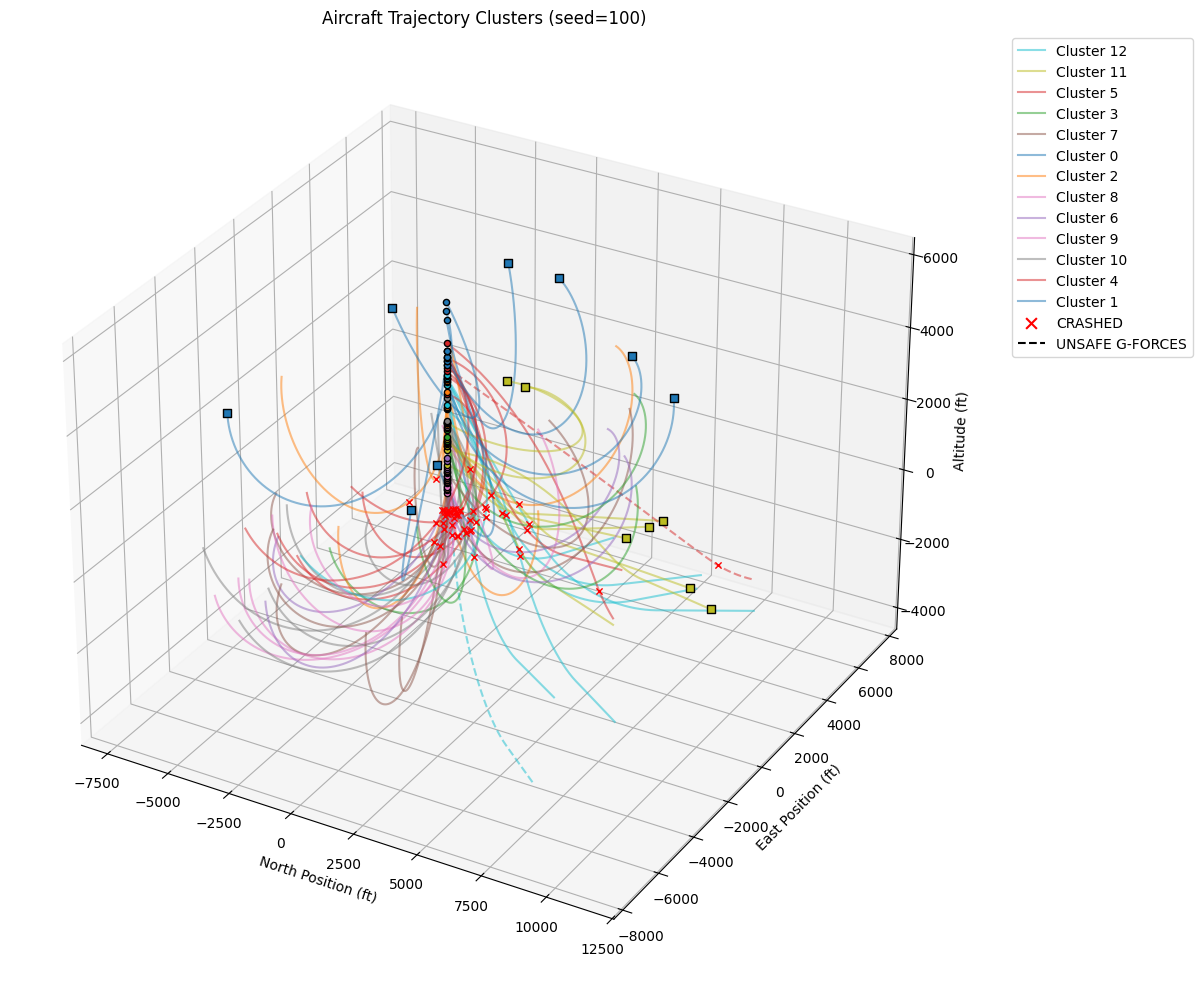

In [ ]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection="3d")

colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))

valid_results = [r for r in results if not r.simulation_failed]

plotted_clusters = set()

for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    if cluster_id == -1:  # Skip noise points
        continue

    color = colors[cluster_id % len(colors)]
    if cluster_id not in plotted_clusters:
        label = f"Cluster {cluster_id}"
        plotted_clusters.add(cluster_id)
    else:
        label = None

    # Check for unsafe g-forces
    has_unsafe_g = has_unsafe_gforces(traj)
    line_style = "--" if has_unsafe_g else "-"

    ax.plot(
        traj[:, 0],
        traj[:, 1],
        traj[:, 2],
        color=color,
        alpha=0.5,
        linewidth=1.5,
        linestyle=line_style,
        label=label,
    )

    # start point
    ax.scatter(
        traj[0, 0],
        traj[0, 1],
        traj[0, 2],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    # end points
    if result.crashed:
        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_x = traj[crash_idx, 0]
            crash_y = traj[crash_idx, 1]
            crash_z = traj[crash_idx, 2]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_x = traj[min_alt_idx, 0]
            crash_y = traj[min_alt_idx, 1]
            crash_z = traj[min_alt_idx, 2]

        ax.scatter(
            crash_x,
            crash_y,
            crash_z,
            color="red",
            s=20,
            marker="x",
            linewidth=1,
        )
    else:
        ax.scatter(
            traj[-1, 0],
            traj[-1, 1],
            traj[-1, 2],
            color=color,
            s=30,
            marker="s",
            edgecolor="black",
            linewidth=1,
        )

if any(result.crashed for result in valid_results):
    ax.scatter([], [], color="red", marker="x", s=60, label="CRASHED")

# Add legend for unsafe g-forces
if any(has_unsafe_gforces(traj) for traj in trajectories):
    ax.plot([], [], color="black", linestyle="--", label="UNSAFE G-FORCES")

ax.set_xlabel("North Position (ft)")
ax.set_ylabel("East Position (ft)")
ax.set_zlabel("Altitude (ft)")
ax.set_title(f"Aircraft Trajectory Clusters (seed={seed})")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
if save_plot:
    plt.savefig(f"results/{seed}_clusters_3d.png")
    print(f"Plot saved to results/{seed}_clusters_3d.png")

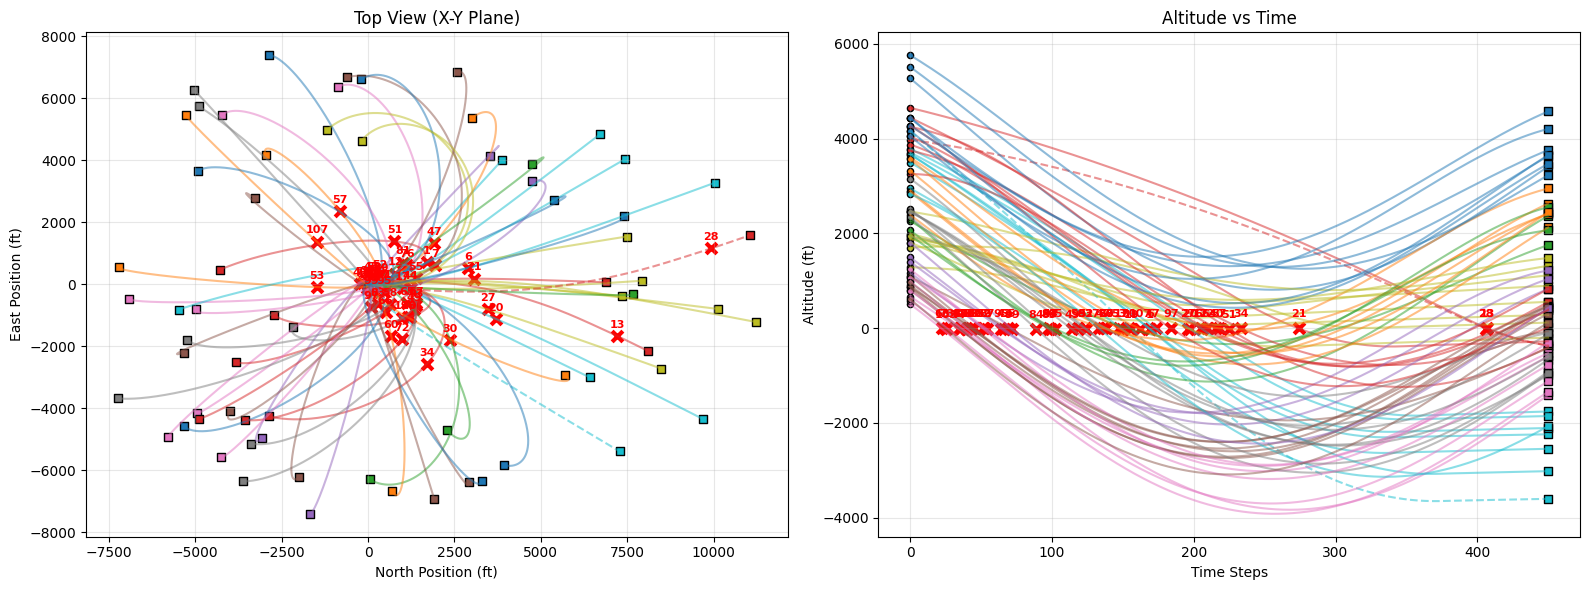

In [ ]:
# 2D plotting - x-y plane and altitude vs time
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# x-y plane
ax1 = axes[0]
for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    if cluster_id == -1:  # Skip noise points
        continue

    color = colors[cluster_id % len(colors)]

    # Check for unsafe g-forces
    has_unsafe_g = has_unsafe_gforces(traj)
    line_style = "--" if has_unsafe_g else "-"

    if result.crashed:
        ax1.plot(
            traj[:, 0],
            traj[:, 1],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle=line_style,
        )

        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_x = traj[crash_idx, 0]
            crash_y = traj[crash_idx, 1]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_x = traj[min_alt_idx, 0]
            crash_y = traj[min_alt_idx, 1]

        ax1.scatter(
            crash_x,
            crash_y,
            color="red",
            s=60,
            marker="x",
            linewidth=3,
        )

        ax1.text(
            crash_x,
            crash_y + 200,
            f"{i}",
            color="red",
            fontsize=8,
            fontweight="bold",
            ha="center",
            va="bottom",
        )
    else:
        ax1.plot(
            traj[:, 0],
            traj[:, 1],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle=line_style,
        )

    ax1.scatter(
        traj[0, 0],
        traj[0, 1],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    ax1.scatter(
        traj[-1, 0],
        traj[-1, 1],
        color=color,
        s=30,
        marker="s",
        edgecolor="black",
        linewidth=1,
    )

ax1.set_xlabel("North Position (ft)")
ax1.set_ylabel("East Position (ft)")
ax1.set_title("Top View (X-Y Plane)")
ax1.grid(True, alpha=0.3)

# altitude vs time
ax2 = axes[1]
for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    if cluster_id == -1:  # Skip noise points
        continue

    color = colors[cluster_id % len(colors)]

    time_steps = np.arange(len(traj))

    # Check for unsafe g-forces
    has_unsafe_g = has_unsafe_gforces(traj)
    line_style = "--" if has_unsafe_g else "-"

    if result.crashed:
        ax2.plot(
            time_steps,
            traj[:, 2],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle=line_style,
        )

        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_time = time_steps[crash_idx]
            crash_z = traj[crash_idx, 2]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_time = time_steps[min_alt_idx]
            crash_z = traj[min_alt_idx, 2]

        ax2.scatter(
            crash_time,
            crash_z,
            color="red",
            s=60,
            marker="x",
            linewidth=3,
        )

        ax2.text(
            crash_time,
            crash_z + 200,
            f"{i}",
            color="red",
            fontsize=8,
            fontweight="bold",
            ha="center",
            va="bottom",
        )
    else:
        ax2.plot(
            time_steps,
            traj[:, 2],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle=line_style,
        )

    ax2.scatter(
        0,
        traj[0, 2],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    ax2.scatter(
        len(traj) - 1,
        traj[-1, 2],
        color=color,
        s=30,
        marker="s",
        edgecolor="black",
        linewidth=1,
    )

ax2.set_xlabel("Time Steps")
ax2.set_ylabel("Altitude (ft)")
ax2.set_title("Altitude vs Time")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
if save_plot:
    plt.savefig(f"results/{seed}_clusters_2d.png")
    print(f"2D plots saved to results/{seed}_clusters_2d.png")

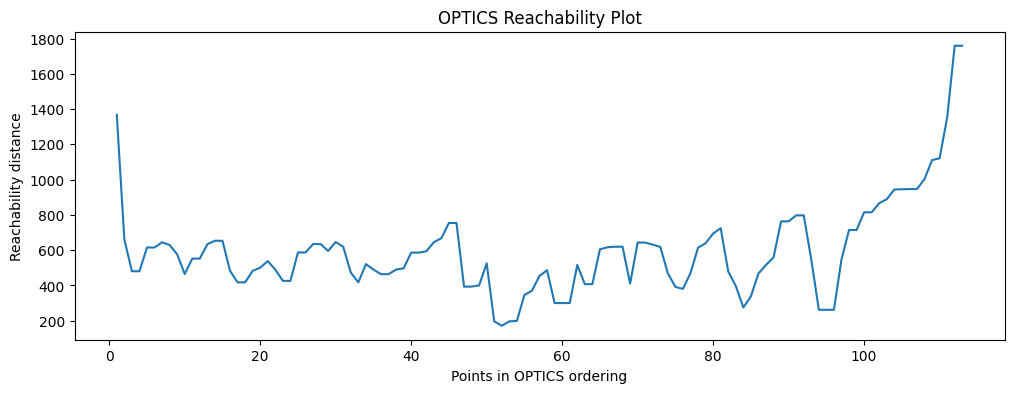

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(reachability[ordering])
plt.xlabel("Points in OPTICS ordering")
plt.ylabel("Reachability distance")
plt.title("OPTICS Reachability Plot")
plt.show()

## Gaussian Mixture Model (GMM) Clustering


In [5]:
# Apply MDS to convert altitude-based distance matrix to feature space
print("Applying MDS transformation...")
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=seed)
X_transformed = mds.fit_transform(distance_matrix)
print(f"MDS transformed features shape: {X_transformed.shape}")
print(f"MDS stress: {mds.stress_:.4f}")

Applying MDS transformation...


/Users/y65ng/Developer/unc/research/code/.venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


MDS transformed features shape: (315, 2)
MDS stress: 6062678377.2501


In [6]:
# Apply GMM clustering with n=5 components based on altitude trajectories
n_components = 5
print(f"Applying GMM clustering with {n_components} components...")
gmm = GaussianMixture(n_components=n_components, random_state=seed)
gmm.fit(X_transformed)

# Apply clustering
clusters = gmm.predict(X_transformed)
cluster_probs = gmm.predict_proba(X_transformed)
unique_clusters = np.unique(clusters)

Applying GMM clustering with 5 components...


In [7]:
# Calculate cluster statistics
for cluster_id in unique_clusters:
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    crashed_in_cluster = sum(1 for r in cluster_results if r.crashed)
    total_in_cluster = len(cluster_results)
    crash_rate = (
        (crashed_in_cluster / total_in_cluster) * 100 if total_in_cluster > 0 else 0
    )
    print(
        f"Cluster {cluster_id}: {crashed_in_cluster}/{total_in_cluster} crashed ({crash_rate:.2f}%)"
    )

Cluster 0: 34/63 crashed (53.97%)
Cluster 1: 0/64 crashed (0.00%)
Cluster 2: 32/32 crashed (100.00%)
Cluster 3: 54/69 crashed (78.26%)
Cluster 4: 85/87 crashed (97.70%)


In [8]:
# Second-stage clustering on mixed (neither all-crashed nor all-safe) clusters
# Identify mixed clusters from the first-stage GMM
mixed_cluster_ids = []
for cluster_id in unique_clusters:
    mask = clusters == cluster_id
    total = int(np.sum(mask))
    if total == 0:
        continue
    crashed = sum(
        1 for i in range(len(valid_results)) if mask[i] and valid_results[i].crashed
    )
    if 0 < crashed < total:
        mixed_cluster_ids.append(int(cluster_id))

print(f"Mixed clusters selected for separate re-clustering: {mixed_cluster_ids}")

# Perform second-stage clustering separately within each mixed cluster
second_stage_results = []  # list of dicts: {parent_id, X, clusters, valid_results}
for parent_id in mixed_cluster_ids:
    parent_mask = clusters == parent_id
    X_parent = X_transformed[parent_mask]
    valid_results_parent = [res for res, m in zip(valid_results, parent_mask) if m]

    print(f"Parent cluster {parent_id}: {len(valid_results_parent)} samples")

    if len(valid_results_parent) >= 2:
        n_components_parent = 5 if len(valid_results_parent) >= 2 else 1
        print(
            f"  Re-clustering parent {parent_id} with {n_components_parent} components..."
        )
        gmm_parent = GaussianMixture(
            n_components=n_components_parent, random_state=seed
        )
        gmm_parent.fit(X_parent)
        clusters_parent = gmm_parent.predict(X_parent)

        # Report stats per second-stage subcluster
        for sub_id in np.unique(clusters_parent):
            sub_mask = clusters_parent == sub_id
            sub_results = [
                valid_results_parent[i]
                for i in range(len(valid_results_parent))
                if sub_mask[i]
            ]
            crashed_in_sub = sum(1 for r in sub_results if r.crashed)
            total_in_sub = len(sub_results)
            crash_rate_sub = (
                (crashed_in_sub / total_in_sub) * 100 if total_in_sub > 0 else 0
            )
            print(
                f"  Parent {parent_id} -> Sub {sub_id}: {crashed_in_sub}/{total_in_sub} crashed ({crash_rate_sub:.2f}%)"
            )

        second_stage_results.append(
            {
                "parent_id": int(parent_id),
                "X": X_parent,
                "clusters": clusters_parent,
                "valid_results": valid_results_parent,
            }
        )
    else:
        print(
            f"  Not enough samples in parent {parent_id} for re-clustering; skipping."
        )

Mixed clusters selected for separate re-clustering: [0, 3, 4]
Parent cluster 0: 63 samples
  Re-clustering parent 0 with 5 components...
  Parent 0 -> Sub 0: 16/17 crashed (94.12%)
  Parent 0 -> Sub 1: 8/26 crashed (30.77%)
  Parent 0 -> Sub 2: 1/7 crashed (14.29%)
  Parent 0 -> Sub 3: 4/8 crashed (50.00%)
  Parent 0 -> Sub 4: 5/5 crashed (100.00%)
Parent cluster 3: 69 samples
  Re-clustering parent 3 with 5 components...
  Parent 3 -> Sub 0: 10/10 crashed (100.00%)
  Parent 3 -> Sub 1: 9/10 crashed (90.00%)
  Parent 3 -> Sub 2: 13/17 crashed (76.47%)
  Parent 3 -> Sub 3: 10/16 crashed (62.50%)
  Parent 3 -> Sub 4: 12/16 crashed (75.00%)
Parent cluster 4: 87 samples
  Re-clustering parent 4 with 5 components...
  Parent 4 -> Sub 0: 14/14 crashed (100.00%)
  Parent 4 -> Sub 1: 12/12 crashed (100.00%)
  Parent 4 -> Sub 2: 16/18 crashed (88.89%)
  Parent 4 -> Sub 3: 23/23 crashed (100.00%)
  Parent 4 -> Sub 4: 20/20 crashed (100.00%)


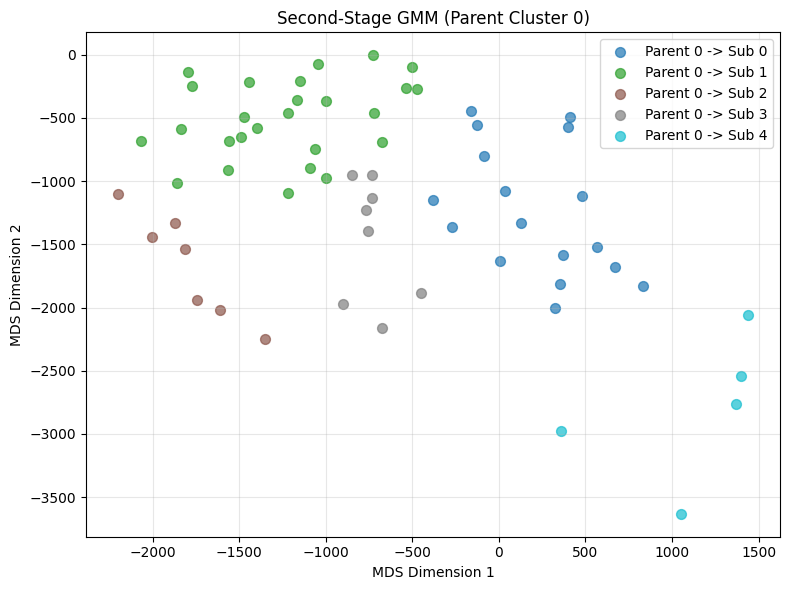

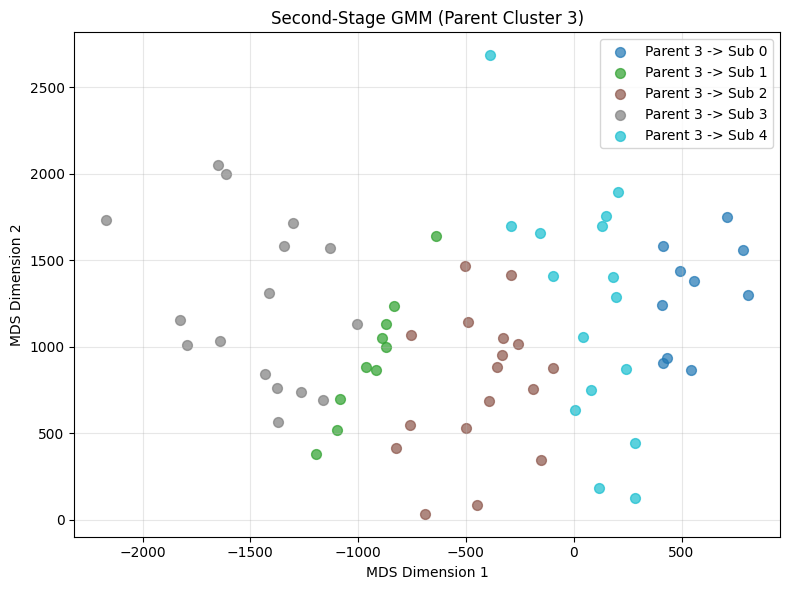

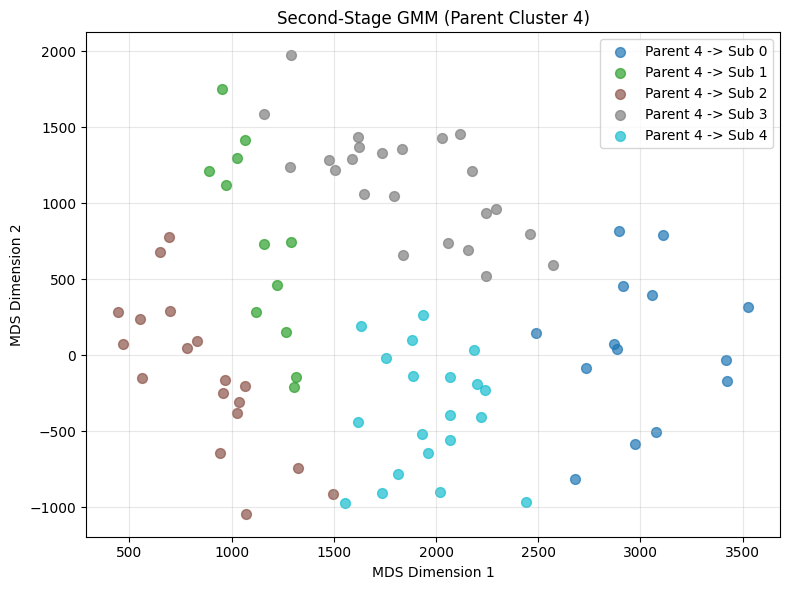

In [9]:
# Visualize second-stage clusters per parent (MDS space)
if "second_stage_results" in globals() and len(second_stage_results) > 0:
    for res in second_stage_results:
        parent_id = res["parent_id"]
        Xp = res["X"]
        cp = res["clusters"]
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(np.unique(cp))))
        for sub_id in np.unique(cp):
            mask = cp == sub_id
            ax.scatter(
                Xp[mask, 0],
                Xp[mask, 1],
                c=[colors[sub_id % len(colors)]],
                label=f"Parent {parent_id} -> Sub {sub_id}",
                alpha=0.7,
                s=50,
            )
        ax.set_xlabel("MDS Dimension 1")
        ax.set_ylabel("MDS Dimension 2")
        ax.set_title(f"Second-Stage GMM (Parent Cluster {parent_id})")
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("Second-stage clustering results not available.")

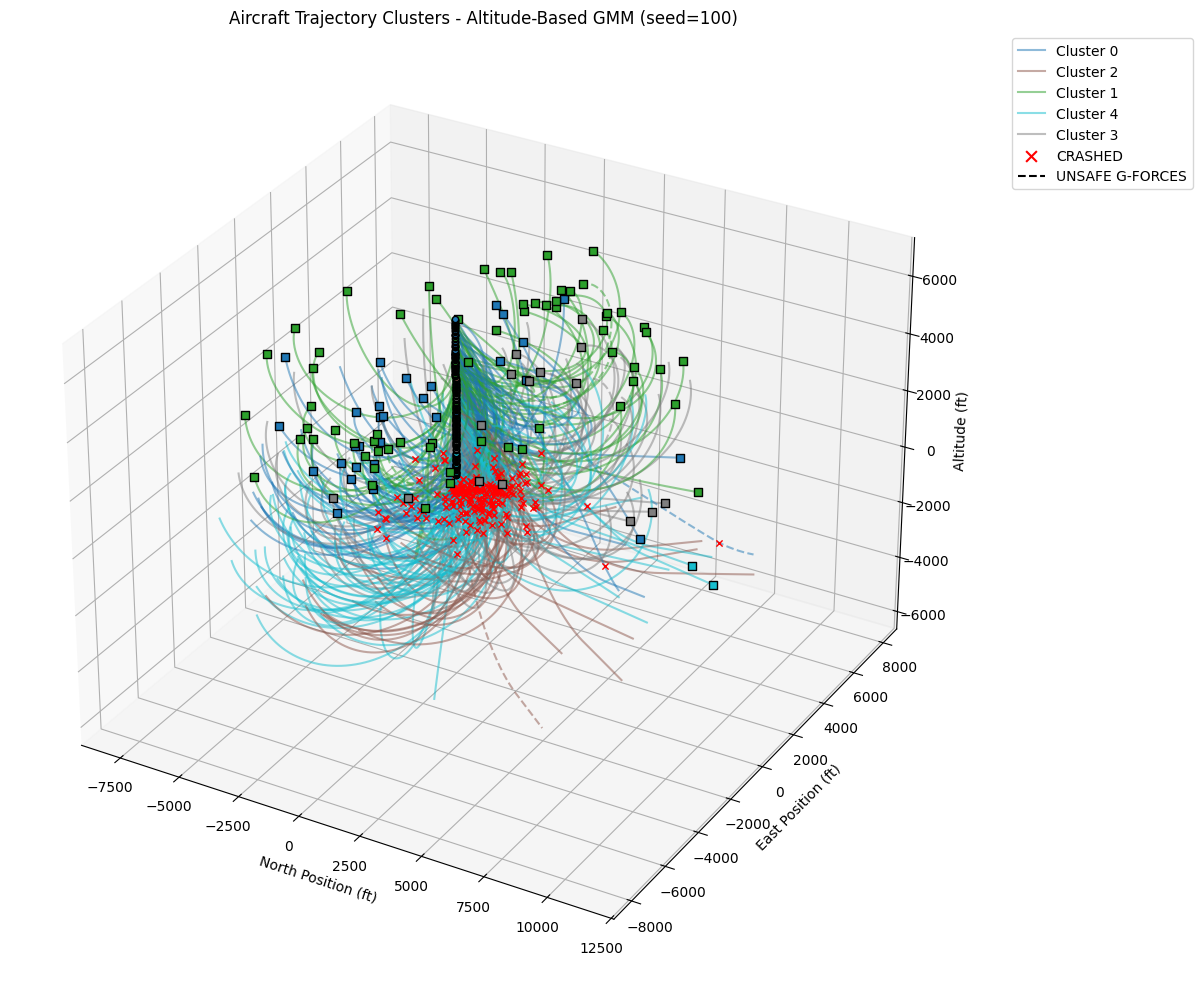

In [10]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection="3d")

colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))

plotted_clusters = set()

for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    color = colors[cluster_id % len(colors)]
    if cluster_id not in plotted_clusters:
        label = f"Cluster {cluster_id}"
        plotted_clusters.add(cluster_id)
    else:
        label = None

    # Check for unsafe g-forces
    has_unsafe_g = has_unsafe_gforces(traj)
    line_style = "--" if has_unsafe_g else "-"

    ax.plot(
        traj[:, 0],
        traj[:, 1],
        traj[:, 2],
        color=color,
        alpha=0.5,
        linewidth=1.5,
        linestyle=line_style,
        label=label,
    )

    # start point
    ax.scatter(
        traj[0, 0],
        traj[0, 1],
        traj[0, 2],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    # end points
    if result.crashed:
        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_x = traj[crash_idx, 0]
            crash_y = traj[crash_idx, 1]
            crash_z = traj[crash_idx, 2]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_x = traj[min_alt_idx, 0]
            crash_y = traj[min_alt_idx, 1]
            crash_z = traj[min_alt_idx, 2]

        ax.scatter(
            crash_x,
            crash_y,
            crash_z,
            color="red",
            s=20,
            marker="x",
            linewidth=1,
        )
    else:
        # Safe landing point
        ax.scatter(
            traj[-1, 0],
            traj[-1, 1],
            traj[-1, 2],
            color=color,
            s=30,
            marker="s",
            edgecolor="black",
            linewidth=1,
        )

# Add legend for crashed trajectories
if any(result.crashed for result in valid_results):
    ax.scatter([], [], color="red", marker="x", s=60, label="CRASHED")

# Add legend for unsafe g-forces
if any(has_unsafe_gforces(traj) for traj in trajectories):
    ax.plot([], [], color="black", linestyle="--", label="UNSAFE G-FORCES")

ax.set_xlabel("North Position (ft)")
ax.set_ylabel("East Position (ft)")
ax.set_zlabel("Altitude (ft)")
ax.set_title(f"Aircraft Trajectory Clusters - Altitude-Based GMM (seed={seed})")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
if save_plot:
    plt.savefig(
        f"results/gmm_{n_components}_clusters_3d.png", dpi=300, bbox_inches="tight"
    )
    print(f"Plot saved to results/gmm_{n_components}_clusters_3d.png")

plt.show()

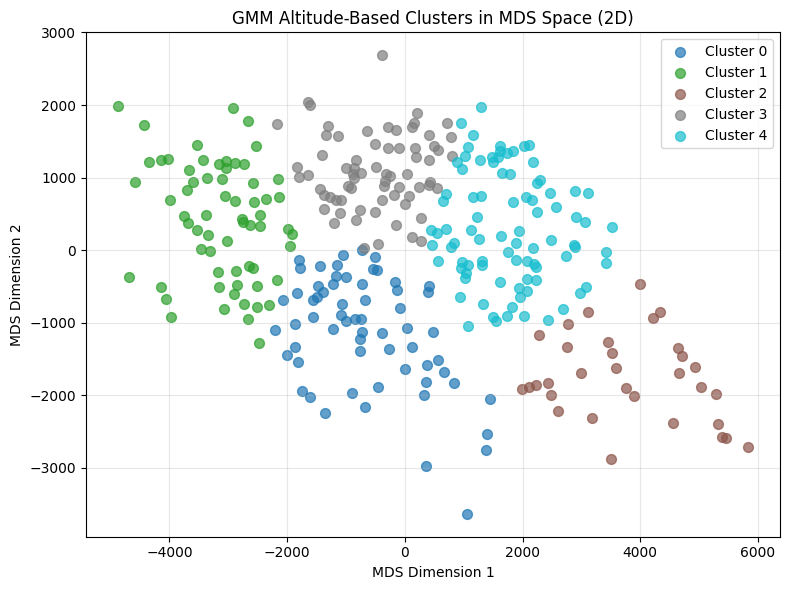

In [11]:
# Visualize clusters in MDS space
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))

colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))

for cluster_id in unique_clusters:
    mask = clusters == cluster_id
    color = colors[cluster_id % len(colors)]

    # Plot first two MDS dimensions
    ax1.scatter(
        X_transformed[mask, 0],
        X_transformed[mask, 1],
        c=[color],
        label=f"Cluster {cluster_id}",
        alpha=0.7,
        s=50,
    )

ax1.set_xlabel("MDS Dimension 1")
ax1.set_ylabel("MDS Dimension 2")
ax1.set_title("GMM Altitude-Based Clusters in MDS Space (2D)")
ax1.legend()
ax1.grid(True, alpha=0.3)


plt.tight_layout()

if save_plot:
    plt.savefig(
        f"results/gmm_{n_components}_clusters_mds.png",
        dpi=300,
        bbox_inches="tight",
    )
    print(f"MDS plot saved to results/gmm_{n_components}_clusters_mds.png")

plt.show()

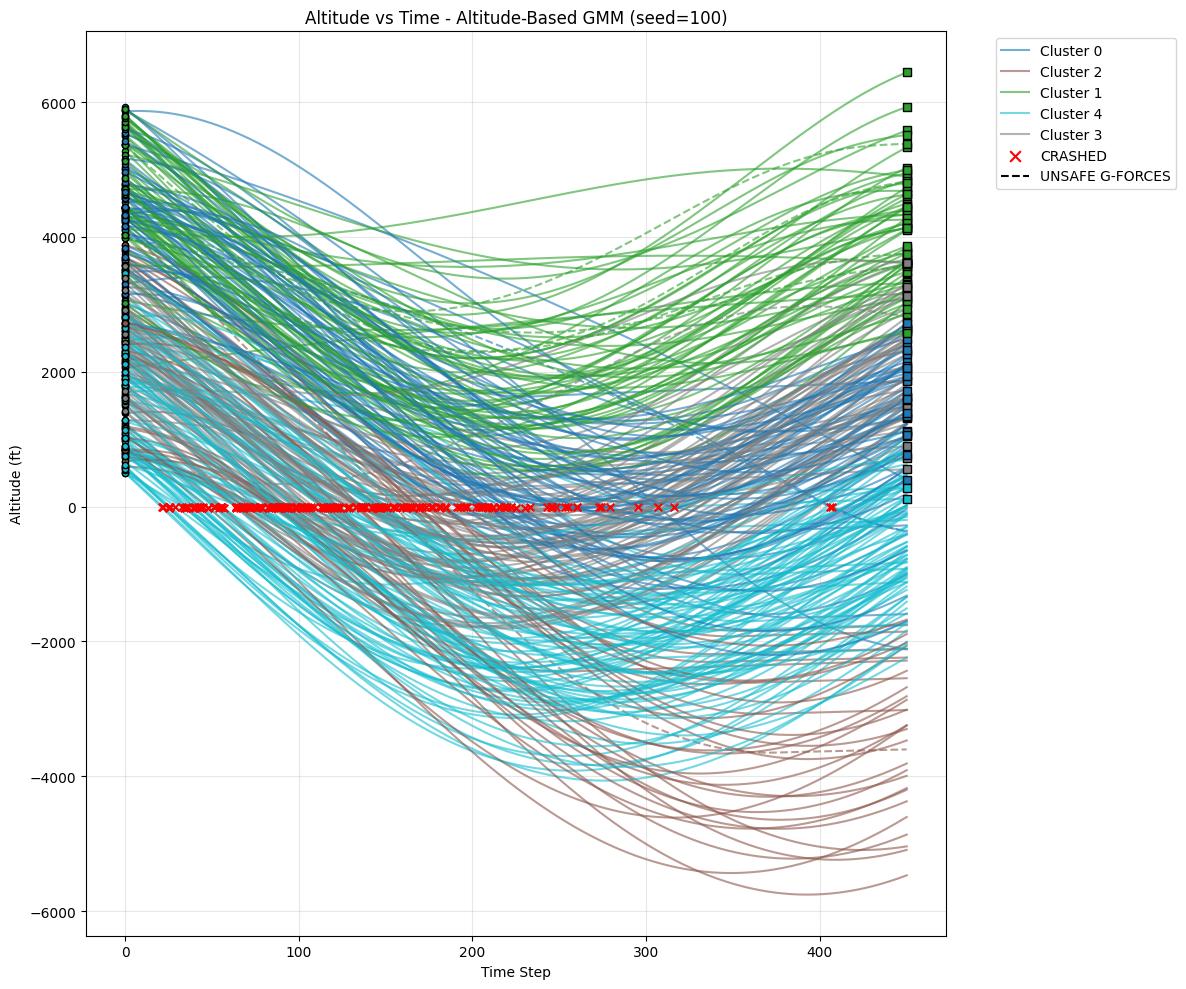

In [12]:
# Altitude vs Time Visualization
fig, ax = plt.subplots(figsize=(12, 10))

colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))
plotted_clusters = set()

for traj, cluster_id, result in zip(trajectories, clusters, valid_results):
    color = colors[cluster_id % len(colors)]
    label = f"Cluster {cluster_id}" if cluster_id not in plotted_clusters else None
    plotted_clusters.add(cluster_id)

    # Style for unsafe g-forces
    line_style = "--" if has_unsafe_gforces(traj) else "-"

    # Time index and altitude
    t = np.arange(traj.shape[0])
    alt = traj[:, 2]

    # Plot altitude vs time
    ax.plot(
        t,
        alt,
        color=color,
        alpha=0.6,
        linewidth=1.5,
        linestyle=line_style,
        label=label,
    )

    # Start point
    ax.scatter(
        0,
        alt[0],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
        zorder=3,
    )

    # End point (crash or safe)
    if result.crashed:
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]
            crash_t = crash_idx
            crash_alt = alt[crash_idx]
        else:
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_t = min_alt_idx
            crash_alt = alt[min_alt_idx]
        ax.scatter(
            crash_t, crash_alt, color="red", s=30, marker="x", linewidth=1.5, zorder=4
        )
    else:
        ax.scatter(
            t[-1],
            alt[-1],
            color=color,
            s=30,
            marker="s",
            edgecolor="black",
            linewidth=1,
            zorder=4,
        )

# Legend handles
if any(result.crashed for result in valid_results):
    ax.scatter([], [], color="red", marker="x", s=60, label="CRASHED")
if any(has_unsafe_gforces(traj) for traj in trajectories):
    ax.plot([], [], color="black", linestyle="--", label="UNSAFE G-FORCES")

ax.set_xlabel("Time Step")
ax.set_ylabel("Altitude (ft)")
ax.set_title(f"Altitude vs Time - Altitude-Based GMM (seed={seed})")
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()

if save_plot:
    os.makedirs("results", exist_ok=True)
    plt.savefig(
        f"results/gmm_{n_components}_clusters_altitude_time.png",
        dpi=300,
        bbox_inches="tight",
    )
    print(f"Plot saved to results/gmm_{n_components}_clusters_altitude_time.png")

plt.show()

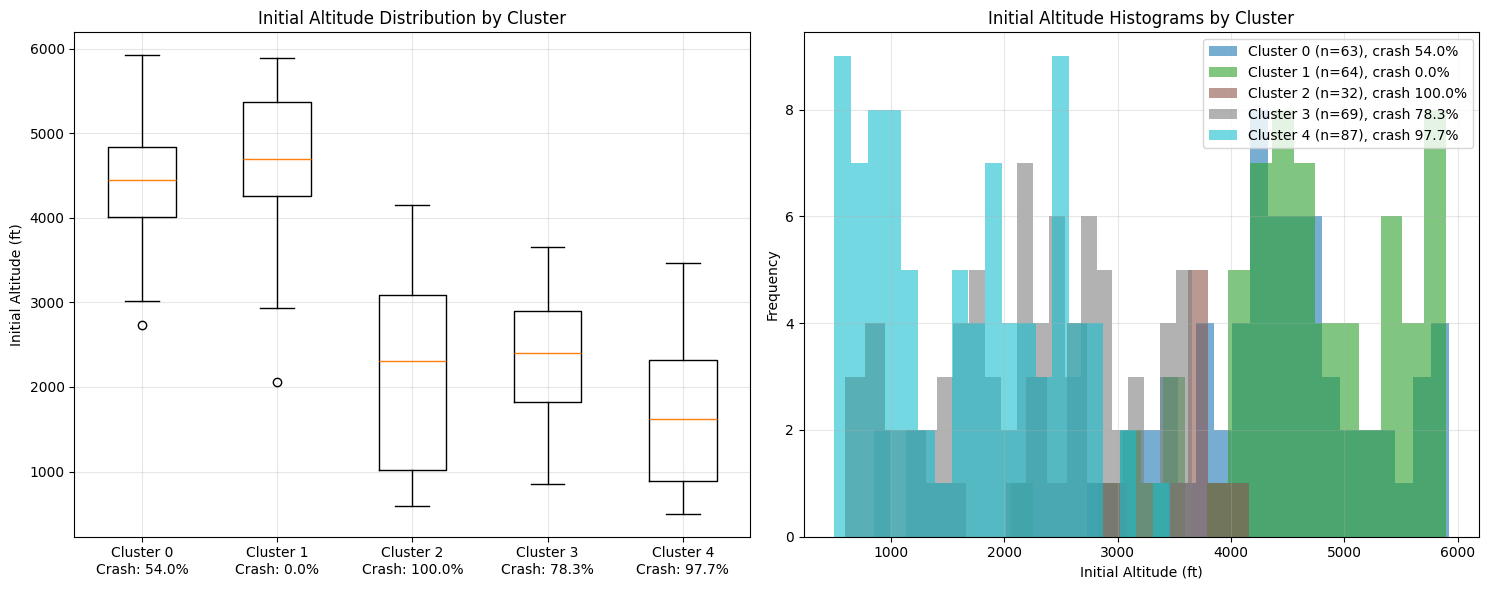

In [13]:
# Visualize altitude distributions by cluster
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Box plot of altitude by cluster
cluster_alts = []
cluster_labels = []
for cluster_id in unique_clusters:
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    cluster_altitudes = [r.test_case.alt for r in cluster_results]
    crashed_count = sum(1 for r in cluster_results if r.crashed)
    total_count = len(cluster_results)
    crash_rate = (crashed_count / total_count) * 100 if total_count > 0 else 0.0
    cluster_alts.append(cluster_altitudes)
    cluster_labels.append(f"Cluster {cluster_id}\nCrash: {crash_rate:.1f}%")

ax1.boxplot(cluster_alts, tick_labels=cluster_labels)
ax1.set_ylabel("Initial Altitude (ft)")
ax1.set_title("Initial Altitude Distribution by Cluster")
ax1.grid(True, alpha=0.3)

# Histogram of altitude distributions
colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))
for i, cluster_id in enumerate(unique_clusters):
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    cluster_altitudes = [r.test_case.alt for r in cluster_results]
    crashed_count = sum(1 for r in cluster_results if r.crashed)
    total_count = len(cluster_results)
    crash_rate = (crashed_count / total_count) * 100 if total_count > 0 else 0.0

    ax2.hist(
        cluster_altitudes,
        bins=20,
        alpha=0.6,
        label=f"Cluster {cluster_id} (n={len(cluster_altitudes)}), crash {crash_rate:.1f}%",
        color=colors[i % len(colors)],
    )

ax2.set_xlabel("Initial Altitude (ft)")
ax2.set_ylabel("Frequency")
ax2.set_title("Initial Altitude Histograms by Cluster")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Variable -> Crash relationship summary
--------------------------------------------------
Altitude (ft)    | corr=-0.581 | safe mean=4237.15 | crash mean=2387.58
Velocity (ft/s)  | corr=-0.078 | safe mean=719.10 | crash mean=708.79
Alpha (deg)      | corr=+0.028 | safe mean=4.92 | crash mean=5.08
Beta (deg)       | corr=+0.014 | safe mean=-1.45 | crash mean=-1.12
Phi (deg)        | corr=-0.020 | safe mean=-5.29 | crash mean=-10.46
Theta (deg)      | corr=-0.087 | safe mean=-45.04 | crash mean=-50.01
Power            | corr=+0.000 | safe mean=9.00 | crash mean=9.00


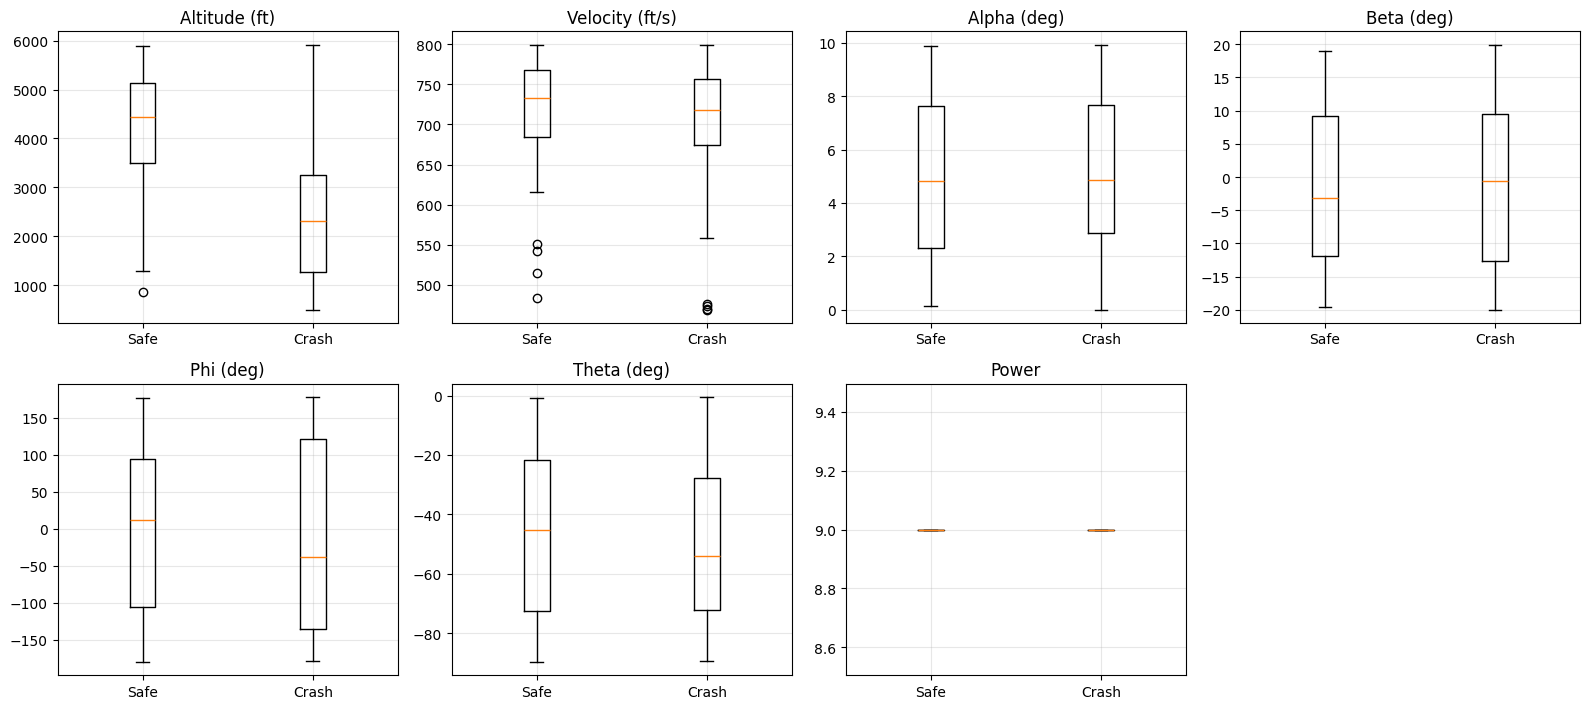

In [14]:
# Relationship of initial variables to crash outcome
from sklearn.metrics import roc_auc_score

# Collect initial variables and crash labels
labels = np.array([1 if r.crashed else 0 for r in valid_results])
vars_dict = {
    "Altitude (ft)": np.array([r.test_case.alt for r in valid_results]),
    "Velocity (ft/s)": np.array([r.test_case.vt for r in valid_results]),
    "Alpha (deg)": np.rad2deg(np.array([r.test_case.alpha for r in valid_results])),
    "Beta (deg)": np.rad2deg(np.array([r.test_case.beta for r in valid_results])),
    "Phi (deg)": np.rad2deg(np.array([r.test_case.phi for r in valid_results])),
    "Theta (deg)": np.rad2deg(np.array([r.test_case.theta for r in valid_results])),
    "Power": np.array([r.test_case.power for r in valid_results]),
}

print("Variable -> Crash relationship summary")
print("-" * 50)
for name, values in vars_dict.items():
    # Pearson correlation with binary label (point-biserial equivalent)
    corr = float(np.corrcoef(values, labels)[0, 1]) if np.std(values) > 0 else 0.0
    safe_vals = values[labels == 0]
    crash_vals = values[labels == 1]
    print(
        f"{name:16s} | corr={corr:+.3f} | safe mean={np.mean(safe_vals):.2f} | crash mean={np.mean(crash_vals):.2f}"
    )

# Boxplots comparing crashed vs safe for each variable
num_vars = len(vars_dict)
cols = 4
rows = int(np.ceil(num_vars / cols))
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3.6 * rows))
axes = axes.flatten()

for ax, (name, values) in zip(axes, vars_dict.items()):
    data = [values[labels == 0], values[labels == 1]]
    ax.boxplot(data, tick_labels=["Safe", "Crash"])
    ax.set_title(name)
    ax.grid(True, alpha=0.3)

# Hide any unused subplots
for j in range(len(vars_dict), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

## Random Forest Regression


In [ ]:
def testcase_to_ndarray(test_case: TestCase) -> np.ndarray:

    return np.array(
        [
            test_case.vt,
            test_case.alpha,
            test_case.beta,
            test_case.phi,
            test_case.theta,
            test_case.psi,
            test_case.alt,
            test_case.power,
        ]
    )


test_cases = [r.test_case for r in valid_results]
features = np.array([testcase_to_ndarray(case) for case in test_cases])
features.shape


def pair_features_between(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    feat_diff = a - b
    feat_abs_diff = np.abs(feat_diff)
    euclidean_dist = np.linalg.norm(feat_diff)
    angular_indices = [1, 2, 3, 4, 5]
    angular_diffs = []
    for idx in angular_indices:
        d = feat_diff[idx]
        while d > np.pi:
            d -= 2 * np.pi
        while d < -np.pi:
            d += 2 * np.pi
        angular_diffs.append(d)
    return np.concatenate([feat_diff, feat_abs_diff, [euclidean_dist], angular_diffs])


def ndarray_to_testcase(arr: Sequence[float]) -> TestCase:
    return TestCase(
        vt=float(arr[0]),
        alpha=float(arr[1]),
        beta=float(arr[2]),
        phi=float(arr[3]),
        theta=float(arr[4]),
        psi=float(arr[5]),
        alt=float(arr[6]),
        power=float(arr[7]),
    )

In [ ]:
def create_pairwise_features(
    features: NDArray[np.float64], distance_matrix: NDArray[np.float64]
) -> Tuple[NDArray[np.float64], NDArray[np.float64]]:
    n = features.shape[0]
    pairwise_features = []
    distances = []

    # Use upper triangular matrix to avoid duplicates
    for i in range(n):
        for j in range(i + 1, n):
            # Feature differences
            feat_diff = features[i] - features[j]
            feat_abs_diff = np.abs(feat_diff)

            # Additional features
            euclidean_dist = np.linalg.norm(feat_diff)

            # Angular differences for angles (alpha, beta, phi, theta, psi)
            angular_indices = [1, 2, 3, 4, 5]  # alpha, beta, phi, theta, psi
            angular_diffs = []
            for idx in angular_indices:
                diff = feat_diff[idx]
                # Normalize to [-pi, pi]
                while diff > np.pi:
                    diff -= 2 * np.pi
                while diff < -np.pi:
                    diff += 2 * np.pi
                angular_diffs.append(diff)

            # Combine all features
            combined_features = np.concatenate(
                [
                    feat_diff,
                    feat_abs_diff,
                    [euclidean_dist],
                    angular_diffs,
                ]
            )

            pairwise_features.append(combined_features)
            distances.append(distance_matrix[i, j])

    return np.array(pairwise_features), np.array(distances)


X, y = create_pairwise_features(features, distance_matrix)

print(f"Pairwise features shape: {X.shape}")
print(f"Distances shape: {y.shape}")

Pairwise features shape: (666, 22)
Distances shape: (666,)


In [ ]:
# Helper methods


def sample_test_cases_with_rf(
    rf_model: RandomForestRegressor,
    scaler: StandardScaler,
    base_features: np.ndarray,
    n_select: int = 20,
    n_candidates: int = 2000,
    seed: int = 100,
    include_selected_in_pool: bool = True,
) -> list[TestCase]:
    rng = np.random.default_rng(seed)
    feat_min = base_features.min(axis=0)
    feat_max = base_features.max(axis=0)
    candidates = rng.uniform(
        low=feat_min, high=feat_max, size=(n_candidates, base_features.shape[1])
    )
    pool = base_features.copy()
    selected = []

    for _ in range(n_select):
        pool_sub = pool
        min_pred = np.full(n_candidates, np.inf, dtype=float)
        batch_size = 512
        for start in range(0, len(pool_sub), batch_size):
            end = min(start + batch_size, len(pool_sub))
            batch = pool_sub[start:end]

            pairs = []
            for b in batch:
                diffs = candidates - b
                abs_diffs = np.abs(diffs)
                eucl = np.linalg.norm(diffs, axis=1, keepdims=True)
                ang_idx = [1, 2, 3, 4, 5]
                ang_diffs = []
                for idx in ang_idx:
                    d = diffs[:, idx].copy()
                    d = (d + np.pi) % (2 * np.pi) - np.pi
                    ang_diffs.append(d.reshape(-1, 1))
                ang_diffs = np.hstack(ang_diffs)
                pair_block = np.hstack([diffs, abs_diffs, eucl, ang_diffs])
                pairs.append(pair_block)

            pairmat = np.vstack(pairs)
            pairmat_scaled = scaler.transform(pairmat)
            preds = rf_model.predict(pairmat_scaled).reshape(-1)
            preds_reshaped = preds.reshape(len(batch), n_candidates)
            batch_min = preds_reshaped.min(axis=0)
            min_pred = np.minimum(min_pred, batch_min)

        best_idx = int(np.argmax(min_pred))
        best = candidates[best_idx]
        selected.append(best)
        if include_selected_in_pool:
            pool = np.vstack([pool, best[None, :]])
        candidates[best_idx] = rng.uniform(
            low=feat_min, high=feat_max, size=(base_features.shape[1],)
        )

    return [ndarray_to_testcase(s) for s in selected]


def run_active_coverage_cycles(
    init_cases: list[TestCase],
    cycles: int = 5,
    per_cycle_new: int = 20,
    n_candidates: int = 2000,
    seed: int = 100,
    cache_distances: bool = True,
):
    rng = np.random.default_rng(seed)
    results_all = evaluate_cases(init_cases)
    trajectories = [r.trajectory for r in results_all if not r.simulation_failed]
    test_cases = [r.test_case for r in results_all if not r.simulation_failed]
    features = np.array([testcase_to_ndarray(tc) for tc in test_cases])

    for c in range(1, cycles + 1):
        distance_matrix_file = (
            f"cache/distance_matrix_seed{seed}_size{len(trajectories)}.npy"
        )
        if cache_distances and os.path.exists(distance_matrix_file):
            distance_matrix = np.load(distance_matrix_file)
        else:
            distance_matrix = pairwise_distances(trajectories)
            if cache_distances:
                np.save(distance_matrix_file, distance_matrix)

        width, uniformity = frechet_coverage(distance_matrix)
        print(
            f"[Cycle {c}] N={len(trajectories)} width={width:.2f} uniformity={uniformity:.4f}"
        )

        X, y = create_pairwise_features(features, distance_matrix)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=seed
        )
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        rf_model = RandomForestRegressor(
            n_estimators=100, max_depth=20, random_state=seed, n_jobs=-1
        )
        rf_model.fit(X_train_scaled, y_train)

        new_cases = sample_test_cases_with_rf(
            rf_model=rf_model,
            scaler=scaler,
            base_features=features,
            n_select=per_cycle_new,
            n_candidates=n_candidates,
            seed=int(rng.integers(0, 1_000_000)),
            include_selected_in_pool=True,
        )

        new_results = evaluate_cases(new_cases)
        new_valid = [r for r in new_results if not r.simulation_failed]
        new_trajs = [r.trajectory for r in new_valid]
        new_feats = np.array([testcase_to_ndarray(r.test_case) for r in new_valid])

        if len(new_trajs) == 0:
            print(f"[Cycle {c}] No valid new trajectories; stopping.")
            break

        results_all.extend(new_valid)
        trajectories.extend(new_trajs)
        features = np.vstack([features, new_feats])

    distance_matrix = pairwise_distances(trajectories)
    width, uniformity = frechet_coverage(distance_matrix)
    print(
        f"[Final] N={len(trajectories)} width={width:.2f} uniformity={uniformity:.4f}"
    )
    return results_all, trajectories, features

In [ ]:
# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set: 532 samples
Test set: 134 samples


In [ ]:
initial_cases = [r.test_case for r in valid_results]

results_all, trajectories_all, features_all = run_active_coverage_cycles(
    init_cases=initial_cases,
    cycles=2,
    per_cycle_new=20,
    n_candidates=2000,
    seed=seed,
    cache_distances=True,
)

TypeError: frechet_coverage() missing 2 required positional arguments: 'bins' and 'hist_range'

In [ ]:
# Train Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=100, max_depth=20, random_state=seed, n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# Make predictions
rf_predictions = rf_model.predict(X_test_scaled)

rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = rf_model.score(X_test_scaled, y_test)


print(f"MAE: {rf_mae:.2f}")
print(f"RMSE: {rf_rmse:.2f}")
print(f"R squared: {rf_r2:.4f}")

MAE: 2513.35
RMSE: 3162.48
R squared: 0.1310


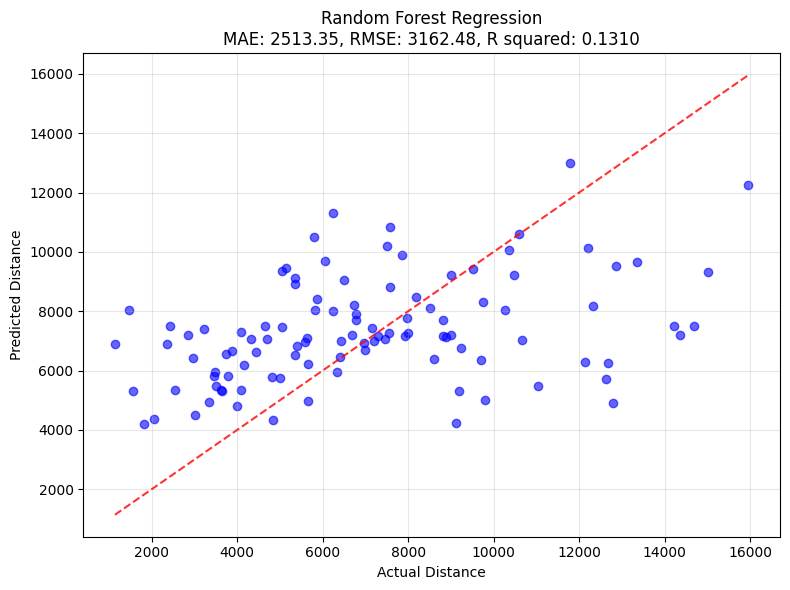

In [ ]:
# Visualize results
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(y_test, rf_predictions, alpha=0.6, color="blue")
min_val = min(y_test.min(), rf_predictions.min())
max_val = max(y_test.max(), rf_predictions.max())
ax.plot([min_val, max_val], [min_val, max_val], "r--", alpha=0.8)
ax.set_xlabel("Actual Distance")
ax.set_ylabel("Predicted Distance")
ax.set_title(
    f"Random Forest Regression\nMAE: {rf_mae:.2f}, RMSE: {rf_rmse:.2f}, R squared: {rf_r2:.4f}"
)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Feature importance analysis
feature_names = [
    "vt_diff",
    "alpha_diff",
    "beta_diff",
    "phi_diff",
    "theta_diff",
    "psi_diff",
    "alt_diff",
    "power_diff",
    "vt_abs_diff",
    "alpha_abs_diff",
    "beta_abs_diff",
    "phi_abs_diff",
    "theta_abs_diff",
    "psi_abs_diff",
    "alt_abs_diff",
    "power_abs_diff",
    "euclidean_dist",
    "alpha_angular_diff",
    "beta_angular_diff",
    "phi_angular_diff",
    "theta_angular_diff",
    "psi_angular_diff",
]

# Get feature importances
rf_importances = rf_model.feature_importances_

# Sort features by importance
rf_indices = np.argsort(rf_importances)[::-1]

print("Top 10 Most Important Features:")
for i in range(min(10, len(feature_names))):
    idx = rf_indices[i]
    print(f"  {i+1}. {feature_names[idx]}: {rf_importances[idx]:.4f}")

Top 10 Most Important Features:
  1. phi_diff: 0.1629
  2. vt_abs_diff: 0.0947
  3. phi_abs_diff: 0.0866
  4. phi_angular_diff: 0.0611
  5. theta_diff: 0.0578
  6. vt_diff: 0.0561
  7. beta_abs_diff: 0.0553
  8. theta_abs_diff: 0.0512
  9. alt_diff: 0.0500
  10. alpha_angular_diff: 0.0496
